# 프로젝트 2: 품질관리 - 불량 원인 & SPC 분석

## 프로젝트 배경

당신은 **한국정밀산업(주)** 품질관리팀의 데이터 분석가입니다.  
최근 주요 고객사로부터 다음과 같은 클레임이 접수되었습니다:

> *"납품받은 샤프트-A(PRD-003) 제품의 직경 치수가 규격을 벗어나는 건이 빈번합니다.  
> 또한 5월 이후 기어박스커버(PRD-005)의 두께가 점점 커지고 있는 것 같습니다.  
> 공정능력(Cpk) 분석 자료와 개선 대책을 제출해 주세요."*

품질팀장은 당신에게 다음 분석을 요청했습니다:

### 분석 목표
1. **불량 현황 파악** - 어떤 유형의 불량이 가장 많고, 어디서 발생하는가?
2. **파레토 분석** - 80/20 법칙으로 핵심 불량 원인 도출
3. **SPC 관리도** - 공정이 관리 상태인지, 특수원인은 없는지 확인
4. **공정능력 분석** - Cp/Cpk로 공정이 규격을 충족하는지 정량 평가
5. **공정 파라미터 영향 분석** - 온도·진동 등이 품질에 미치는 영향 분석

### 데이터 설명

| 파일 | 설명 | 주요 컬럼 |
|------|------|----------|
| `p2_product_spec.csv` | 제품별 측정항목 규격 (24건) | product_code, spec_name, target_value, lsl, usl |
| `p2_inspection_log.csv` | 품질 측정 기록 (~42,000건) | lot_no, measurement, result, inspector_id |
| `p2_defect_log.csv` | 불량 상세 기록 (~770건) | defect_type, cause, severity, defect_qty |
| `p2_process_params.csv` | 공정 파라미터 (~1,700건) | temperature_c, vibration_mms, has_defect |

### SPC 핵심 개념

```
공정능력지수 (Cp)  = (USL - LSL) / (6σ)        → 산포 대비 공차 여유
치우침 공정능력 (Cpk) = min(CPU, CPL)            → 편향까지 고려
  CPU = (USL - X̄) / (3σ)
  CPL = (X̄ - LSL) / (3σ)

판정 기준:
  Cpk ≥ 1.33 : 공정능력 충분
  1.0 ≤ Cpk < 1.33 : 관리 필요
  Cpk < 1.0 : 공정능력 부족 → 개선 필수
```

---

## Part 0: 환경 설정 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

# 한글 폰트 설정
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
spec = pd.read_csv('../data/project2/p2_product_spec.csv', encoding='utf-8-sig')
insp = pd.read_csv('../data/project2/p2_inspection_log.csv', encoding='utf-8-sig')
defect = pd.read_csv('../data/project2/p2_defect_log.csv', encoding='utf-8-sig')
params = pd.read_csv('../data/project2/p2_process_params.csv', encoding='utf-8-sig')

# 날짜 변환
insp['inspection_date'] = pd.to_datetime(insp['inspection_date'])
defect['defect_date'] = pd.to_datetime(defect['defect_date'])
params['record_date'] = pd.to_datetime(params['record_date'])

print('데이터 로드 완료!')
print(f'규격: {len(spec)}건 | 측정: {len(insp):,}건 | 불량: {len(defect)}건 | 공정파라미터: {len(params):,}건')

데이터 로드 완료!
규격: 24건 | 측정: 42,560건 | 불량: 767건 | 공정파라미터: 1,716건


---
## Part 1: 데이터 탐색 및 전처리 (15점)

품질 데이터는 여러 소스에서 수집됩니다.  
검사 장비 오류, 미기록, 검사원 실수 등으로 결측치가 존재합니다.

### 문제 1-1: 데이터 탐색 (5점)

1. 4개 데이터프레임의 shape, 컬럼, 처음 5행을 확인하세요
2. `spec` 테이블에서 제품별 측정항목 수를 확인하세요
3. `insp` 테이블의 결측치 현황을 파악하세요
4. `defect` 테이블의 결측치 현황을 파악하세요
5. `insp`의 `result` 컬럼에서 PASS/FAIL 비율을 확인하세요

In [2]:
# 1. 4개 데이터프레임의 shape, 컬럼, 처음 5행을 확인하세요
## spec
print(spec.shape)
print(list(spec.columns))
spec.head(5)

(24, 8)
['product_code', 'product_name', 'spec_name', 'unit', 'target_value', 'lsl', 'usl', 'tolerance']


,product_code,product_name,spec_name,unit,target_value,lsl,usl,tolerance
0,PRD-001,베어링하우징-S,외경,mm,50.0,49.95,50.05,0.10
1,PRD-001,베어링하우징-S,내경,mm,30.0,29.96,30.04,0.08
2,PRD-001,베어링하우징-S,높이,mm,25.0,24.95,25.05,0.10
3,PRD-001,베어링하우징-S,표면조도,Ra,1.6,0.00,3.20,3.20
4,PRD-002,베어링하우징-M,외경,mm,80.0,79.94,80.06,0.12


In [3]:
## insp
print(insp.shape)
print(list(insp.columns))
insp.head(5)

(42560, 16)
['inspection_id', 'lot_id', 'lot_no', 'inspection_date', 'shift', 'line', 'product_code', 'spec_name', 'unit', 'target_value', 'lsl', 'usl', 'measurement', 'result', 'sample_no', 'inspector_id']


,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07


In [4]:
## defect
print(defect.shape)
print(list(defect.columns))
defect.head(5)

(767, 11)
['defect_id', 'defect_date', 'line', 'shift', 'product_code', 'defect_type', 'cause', 'severity', 'defect_qty', 'action', 'inspector_id']


,defect_id,defect_date,line,shift,product_code,defect_type,cause,severity,defect_qty,action,inspector_id
0,DEF-00001,2024-01-01,A라인,야간,PRD-004,외관불량,스크래치,보통,11,재작업,INS-05
1,DEF-00002,2024-01-01,A라인,주간,PRD-001,표면조도불량,소재불량,보통,1,특채(조건부합격),INS-05
2,DEF-00003,2024-01-01,A라인,야간,PRD-004,치수불량,셋업오류,보통,7,폐기,INS-01
3,DEF-00004,2024-01-02,A라인,야간,PRD-003,치수불량,공구마모,보통,3,폐기,INS-01
4,DEF-00005,2024-01-02,A라인,야간,PRD-004,형상불량,평탄도초과,보통,1,특채(조건부합격),INS-07


In [5]:
## params
print(params.shape)
print(list(params.columns))
params.head(5)

(1716, 12)
['param_id', 'record_date', 'shift', 'line', 'product_code', 'temperature_c', 'pressure_bar', 'spindle_speed_rpm', 'feed_rate_mmmin', 'coolant_flow_lmin', 'vibration_mms', 'has_defect']


,param_id,record_date,shift,line,product_code,temperature_c,pressure_bar,spindle_speed_rpm,feed_rate_mmmin,coolant_flow_lmin,vibration_mms,has_defect
0,PP-00001,2024-01-01,주간,A라인,PRD-004,42.8,3.75,3343.0,217.5,14.8,0.526,0
1,PP-00002,2024-01-01,주간,A라인,PRD-001,40.0,5.23,2751.0,207.9,16.2,0.323,0
2,PP-00003,2024-01-01,야간,A라인,PRD-003,44.0,4.94,2912.0,199.2,17.4,0.751,0
3,PP-00004,2024-01-01,야간,A라인,PRD-004,38.7,5.21,2736.0,160.1,13.8,0.826,0
4,PP-00005,2024-01-01,주간,B라인,PRD-006,38.3,4.68,3143.0,191.9,13.5,0.470,0


In [6]:
# 2. `spec` 테이블에서 제품별 측정항목 수를 확인하세요
spec['product_code'].value_counts()

product_code
PRD-001    4
PRD-002    4
PRD-003    4
PRD-004    4
PRD-005    4
PRD-006    4
Name: count, dtype: int64

In [7]:
# 3. `insp` 테이블의 결측치 현황을 파악하세요
insp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42560 entries, 0 to 42559
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inspection_id    42560 non-null  object        
 1   lot_id           42560 non-null  object        
 2   lot_no           42560 non-null  object        
 3   inspection_date  42560 non-null  datetime64[ns]
 4   shift            42560 non-null  object        
 5   line             42560 non-null  object        
 6   product_code     42560 non-null  object        
 7   spec_name        42560 non-null  object        
 8   unit             42560 non-null  object        
 9   target_value     42560 non-null  float64       
 10  lsl              42560 non-null  float64       
 11  usl              42560 non-null  float64       
 12  measurement      41302 non-null  float64       
 13  result           41302 non-null  object        
 14  sample_no        42560 non-null  int64

In [8]:
# 4. `defect` 테이블의 결측치 현황을 파악하세요
defect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   defect_id     767 non-null    object        
 1   defect_date   767 non-null    datetime64[ns]
 2   line          767 non-null    object        
 3   shift         767 non-null    object        
 4   product_code  767 non-null    object        
 5   defect_type   767 non-null    object        
 6   cause         735 non-null    object        
 7   severity      767 non-null    object        
 8   defect_qty    767 non-null    int64         
 9   action        761 non-null    object        
 10  inspector_id  767 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 66.0+ KB


In [9]:
# 5. `insp`의 `result` 컬럼에서 PASS/FAIL 비율을 확인하세요
insp['result'].value_counts()

result
PASS    40909
FAIL      393
Name: count, dtype: int64

### 문제 1-2: 결측치 처리 (5점)

1. `insp`에서 `measurement`가 NaN인 행은 **측정 장비 오류**입니다 → 해당 행 삭제
2. `defect`에서 `cause`가 NaN인 건은 → `'원인미상'`으로 대체
3. `defect`에서 `action`이 NaN인 건은 → `'미처리'`로 대체
4. `params`에서 수치형 컬럼의 NaN은 → 해당 라인의 평균값으로 대체
5. 처리 후 모든 테이블의 결측치가 0인지 확인

In [10]:
# 1. `insp`에서 `measurement`가 NaN인 행은 **측정 장비 오류**입니다 → 해당 행 삭제
insp = insp.dropna()
insp

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42555,QC-042556,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,표면조도,Ra,3.2,0.00,6.30,1.3494,PASS,4,INS-06
42556,QC-042557,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,두께,mm,8.0,7.95,8.05,8.0227,PASS,5,INS-06
42557,QC-042558,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,평탄도,mm,0.0,0.00,0.05,0.0038,PASS,5,INS-06
42558,QC-042559,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,볼트홀간거리,mm,120.0,119.95,120.05,120.0120,PASS,5,INS-06


In [11]:
# 2. `defect`에서 `cause`가 NaN인 건은 → `'원인미상'`으로 대체
defect['cause'] = defect['cause'].fillna('원인미상')
defect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   defect_id     767 non-null    object        
 1   defect_date   767 non-null    datetime64[ns]
 2   line          767 non-null    object        
 3   shift         767 non-null    object        
 4   product_code  767 non-null    object        
 5   defect_type   767 non-null    object        
 6   cause         767 non-null    object        
 7   severity      767 non-null    object        
 8   defect_qty    767 non-null    int64         
 9   action        761 non-null    object        
 10  inspector_id  767 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 66.0+ KB


In [12]:
# 3. `defect`에서 `action`이 NaN인 건은 → `'미처리'`로 대체
defect['action'] = defect['action'].fillna('미처리')
defect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   defect_id     767 non-null    object        
 1   defect_date   767 non-null    datetime64[ns]
 2   line          767 non-null    object        
 3   shift         767 non-null    object        
 4   product_code  767 non-null    object        
 5   defect_type   767 non-null    object        
 6   cause         767 non-null    object        
 7   severity      767 non-null    object        
 8   defect_qty    767 non-null    int64         
 9   action        767 non-null    object        
 10  inspector_id  767 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 66.0+ KB


In [13]:
# 4. `params`에서 수치형 컬럼의 NaN은 → 해당 라인의 평균값으로 대체
params_temp_mean = params.groupby('line')['temperature_c'].transform('mean')
params_cflow_mean = params.groupby('line')['coolant_flow_lmin'].transform('mean')
params_vib_mean = params.groupby('line')['vibration_mms'].transform('mean')

params['temperature_c'] = params['temperature_c'].fillna(params_temp_mean)
params['coolant_flow_lmin'] = params['coolant_flow_lmin'].fillna(params_cflow_mean)
params['vibration_mms'] = params['vibration_mms'].fillna(params_vib_mean)

In [14]:
params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   param_id           1716 non-null   object        
 1   record_date        1716 non-null   datetime64[ns]
 2   shift              1716 non-null   object        
 3   line               1716 non-null   object        
 4   product_code       1716 non-null   object        
 5   temperature_c      1716 non-null   float64       
 6   pressure_bar       1716 non-null   float64       
 7   spindle_speed_rpm  1716 non-null   float64       
 8   feed_rate_mmmin    1716 non-null   float64       
 9   coolant_flow_lmin  1716 non-null   float64       
 10  vibration_mms      1716 non-null   float64       
 11  has_defect         1716 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 161.0+ KB


### 문제 1-3: 파생 컬럼 생성 (5점)

`insp` 테이블에 분석용 파생 컬럼을 추가하세요:

1. `month` - 검사월
2. `deviation` - 편차 = measurement - target_value (목표값 대비 얼마나 벗어났는가)
3. `is_fail` - FAIL 여부 (0 또는 1)
4. `within_spec` - 규격 이내 여부 (True/False, lsl ≤ measurement ≤ usl)

`defect` 테이블에도 추가:
5. `month` - 불량 발생월

In [15]:
# 1. `month` - 검사월
insp['month'] = insp['inspection_date'].dt.month
insp

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id,month
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07,1
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07,1
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07,1
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07,1
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42555,QC-042556,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,표면조도,Ra,3.2,0.00,6.30,1.3494,PASS,4,INS-06,6
42556,QC-042557,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,두께,mm,8.0,7.95,8.05,8.0227,PASS,5,INS-06,6
42557,QC-042558,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,평탄도,mm,0.0,0.00,0.05,0.0038,PASS,5,INS-06,6
42558,QC-042559,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,볼트홀간거리,mm,120.0,119.95,120.05,120.0120,PASS,5,INS-06,6


In [16]:
# 2. `deviation` - 편차 = measurement - target_value (목표값 대비 얼마나 벗어났는가)
insp['deviation'] = insp['measurement'] - insp['target_value']
insp

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id,month,deviation
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07,1,0.0285
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07,1,0.0110
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07,1,0.0165
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07,1,0.6534
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07,1,0.0093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42555,QC-042556,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,표면조도,Ra,3.2,0.00,6.30,1.3494,PASS,4,INS-06,6,-1.8506
42556,QC-042557,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,두께,mm,8.0,7.95,8.05,8.0227,PASS,5,INS-06,6,0.0227
42557,QC-042558,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,평탄도,mm,0.0,0.00,0.05,0.0038,PASS,5,INS-06,6,0.0038
42558,QC-042559,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,볼트홀간거리,mm,120.0,119.95,120.05,120.0120,PASS,5,INS-06,6,0.0120


In [17]:
# 3. `is_fail` - FAIL 여부 (0 또는 1)
insp['is_fail'] = insp['result'] == 'FAIL'
insp

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id,month,deviation,is_fail
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07,1,0.0285,False
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07,1,0.0110,False
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07,1,0.0165,False
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07,1,0.6534,False
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07,1,0.0093,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42555,QC-042556,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,표면조도,Ra,3.2,0.00,6.30,1.3494,PASS,4,INS-06,6,-1.8506,False
42556,QC-042557,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,두께,mm,8.0,7.95,8.05,8.0227,PASS,5,INS-06,6,0.0227,False
42557,QC-042558,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,평탄도,mm,0.0,0.00,0.05,0.0038,PASS,5,INS-06,6,0.0038,False
42558,QC-042559,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,볼트홀간거리,mm,120.0,119.95,120.05,120.0120,PASS,5,INS-06,6,0.0120,False


In [18]:
# 4. `within_spec` - 규격 이내 여부 (True/False, lsl ≤ measurement ≤ usl)
insp['within_spec'] = (insp['lsl'] <= insp['measurement']) & (insp['measurement'] <= insp['usl'])
insp

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id,month,deviation,is_fail,within_spec
0,QC-000001,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0285,PASS,1,INS-07,1,0.0285,False,True
1,QC-000002,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,내경,mm,30.0,29.96,30.04,30.0110,PASS,1,INS-07,1,0.0110,False,True
2,QC-000003,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,높이,mm,25.0,24.95,25.05,25.0165,PASS,1,INS-07,1,0.0165,False,True
3,QC-000004,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,표면조도,Ra,1.6,0.00,3.20,2.2534,PASS,1,INS-07,1,0.6534,False,True
4,QC-000005,L00001,LOT-240101-A주-001,2024-01-01,주간,A라인,PRD-001,외경,mm,50.0,49.95,50.05,50.0093,PASS,2,INS-07,1,0.0093,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42555,QC-042556,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,표면조도,Ra,3.2,0.00,6.30,1.3494,PASS,4,INS-06,6,-1.8506,False,True
42556,QC-042557,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,두께,mm,8.0,7.95,8.05,8.0227,PASS,5,INS-06,6,0.0227,False,True
42557,QC-042558,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,평탄도,mm,0.0,0.00,0.05,0.0038,PASS,5,INS-06,6,0.0038,False,True
42558,QC-042559,L42541,LOT-240629-C주-005,2024-06-29,주간,C라인,PRD-005,볼트홀간거리,mm,120.0,119.95,120.05,120.0120,PASS,5,INS-06,6,0.0120,False,True


In [19]:
# `defect` 테이블에도 추가: 5. `month` - 불량 발생월
defect['month'] = defect['defect_date'].dt.month
defect

,defect_id,defect_date,line,shift,product_code,defect_type,cause,severity,defect_qty,action,inspector_id,month
0,DEF-00001,2024-01-01,A라인,야간,PRD-004,외관불량,스크래치,보통,11,재작업,INS-05,1
1,DEF-00002,2024-01-01,A라인,주간,PRD-001,표면조도불량,소재불량,보통,1,특채(조건부합격),INS-05,1
2,DEF-00003,2024-01-01,A라인,야간,PRD-004,치수불량,셋업오류,보통,7,폐기,INS-01,1
3,DEF-00004,2024-01-02,A라인,야간,PRD-003,치수불량,공구마모,보통,3,폐기,INS-01,1
4,DEF-00005,2024-01-02,A라인,야간,PRD-004,형상불량,평탄도초과,보통,1,특채(조건부합격),INS-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
762,DEF-00763,2024-06-28,A라인,야간,PRD-001,외관불량,스크래치,경미,5,재작업,INS-06,6
763,DEF-00764,2024-06-28,C라인,주간,PRD-001,외관불량,찍힘,심각,5,폐기,INS-08,6
764,DEF-00765,2024-06-29,A라인,야간,PRD-001,외관불량,스크래치,경미,11,재작업,INS-02,6
765,DEF-00766,2024-06-29,B라인,야간,PRD-002,크랙,원인미상,경미,9,특채(조건부합격),INS-08,6


---
## Part 2: 불량 분석 (25점)

품질관리의 첫 단계는 **현황 파악**입니다.  
어떤 불량이 가장 많이 발생하고, 어디서, 왜 발생하는지 데이터로 확인합니다.

> **현업 포인트**: 파레토 법칙(80/20 법칙) - 상위 20%의 원인이 전체 불량의 80%를 차지합니다.  
> 모든 문제를 동시에 해결하려 하지 말고, 핵심 소수에 집중하세요.

### 문제 2-1: 불량 유형별 파레토 분석 (10점)

1. 불량 유형별 **불량 수량(defect_qty) 합계**를 집계하세요 (건수가 아니라 수량!)
2. 내림차순 정렬 후 **누적 비율(%)**을 계산하세요
3. **파레토 차트**를 그리세요:
   - 막대: 불량 유형별 수량 합계
   - 선: 누적 비율 (%)
   - 80% 기준선 표시
   - Figure 크기: (12, 6)
4. 상위 2~3개 유형으로 전체 불량의 80% 이상을 설명할 수 있는지 확인

In [20]:
# 1. 불량 유형별 **불량 수량(defect_qty) 합계**를 집계하세요 (건수가 아니라 수량!)
type_qty = defect.groupby('defect_type')['defect_qty'].sum()
type_qty

defect_type
기타         437
외관불량      2320
치수불량      1824
크랙         507
표면조도불량     879
형상불량       852
Name: defect_qty, dtype: int64

In [21]:
# 2. 내림차순 정렬 후 **누적 비율(%)**을 계산하세요
type_qty = type_qty.sort_values(ascending=False)
type_qty = pd.concat([type_qty, type_qty.cumsum()/type_qty.cumsum().iloc[-1]*100], axis=1)
type_qty.columns = ['불량 수량', '누적 비율(%)']
type_qty

,불량 수량,누적 비율(%)
defect_type,,
외관불량,2320,34.022584
치수불량,1824,60.771374
표면조도불량,879,73.661827
형상불량,852,86.156328
크랙,507,93.591436
기타,437,100.000000


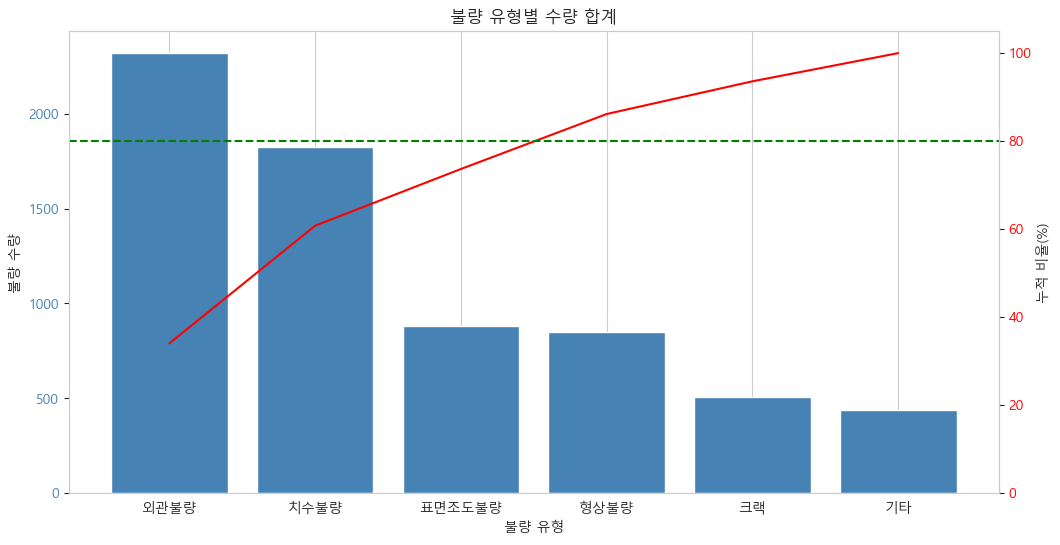

In [22]:
# 3. **파레토 차트**를 그리세요:
#    - 막대: 불량 유형별 수량 합계
#    - 선: 누적 비율 (%)
#    - 80% 기준선 표시
#    - Figure 크기: (12, 6)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(type_qty.index, type_qty['불량 수량'], color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_ylabel('불량 수량')
ax1.set_xlabel('불량 유형')
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(type_qty['누적 비율(%)'], color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('누적 비율(%)')
ax2.set_ylim(0, 105)
ax2.grid(False)
ax2.axhline(80, linestyle='--', color='green')

plt.title('불량 유형별 수량 합계')

plt.show()

In [23]:
# 4. 상위 2~3개 유형으로 전체 불량의 80% 이상을 설명할 수 있는지 확인
# 상위 4개 유형으로 설명 가능

### 문제 2-2: 라인별·제품별 불량 분석 (5점)

1. 라인별 불량 수량 합계와 불량 건수를 비교하세요
2. `line`(행) × `defect_type`(열)의 불량 수량 피벗 테이블 → **히트맵**
3. 제품별 불량 수량 Top 5를 구하고, 어떤 불량 유형이 주로 발생하는지 확인

In [24]:
# 1. 라인별 불량 수량 합계와 불량 건수를 비교하세요
defect.groupby('line').agg({'defect_qty':'sum', 'defect_id':'count'}).sort_values('defect_qty', ascending=False)

,defect_qty,defect_id
line,,
A라인,2986,321
C라인,2037,242
B라인,1796,204


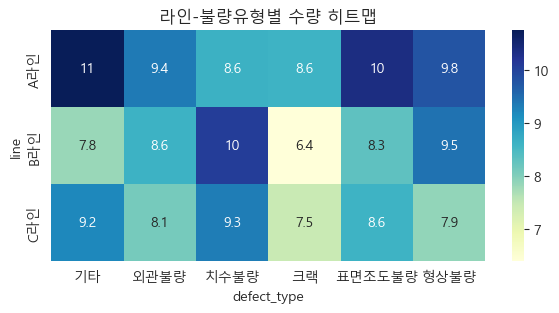

In [25]:
# 2. `line`(행) × `defect_type`(열)의 불량 수량 피벗 테이블 → **히트맵**
plt.figure(figsize=(7, 3))
line_type_pivot = pd.pivot_table(data=defect, index='line', columns='defect_type', values='defect_qty')
sns.heatmap(data=line_type_pivot, annot=True, cmap='YlGnBu')

plt.title('라인-불량유형별 수량 히트맵')
plt.show()

In [26]:
# 3. 제품별 불량 수량 Top 5를 구하고, 어떤 불량 유형이 주로 발생하는지 확인

def temp_fnc(x):
    x.max()

prod_defect_type_5 = defect.groupby('product_code')['defect_qty'].sum().nlargest(5)
pd.pivot_table(data=defect, index='product_code', columns='defect_type', values='defect_id', aggfunc='count', margins=True)

defect_type,기타,외관불량,치수불량,크랙,표면조도불량,형상불량,All
product_code,,,,,,,
PRD-001,11,64,56,19,25,15,190
PRD-002,7,22,12,9,10,8,68
PRD-003,11,62,49,13,24,21,180
PRD-004,4,41,27,8,8,14,102
PRD-005,14,56,39,11,23,18,161
PRD-006,1,20,16,7,5,17,66
All,48,265,199,67,95,93,767


### 문제 2-3: 월별 불량 추이 분석 (5점)

1. 월별 총 불량 수량 추이를 **라인별 라인 차트**로 시각화
2. 5월 이후 B라인 불량이 증가했는지 확인
3. 심각도(severity)별 월별 추이도 확인하세요

> B라인에서 5월 이후 이상 징후가 보이면 Part 3에서 SPC로 원인을 추적합니다.

In [27]:
# 1. 월별 총 불량 수량 추이를 **라인별 라인 차트**로 시각화
monthly_line_defect = defect.groupby(['month', 'line'])['defect_qty'].sum().reset_index()
monthly_line_defect

,month,line,defect_qty
0,1,A라인,601
1,1,B라인,164
2,1,C라인,425
3,2,A라인,502
4,2,B라인,135
5,2,C라인,295
6,3,A라인,529
7,3,B라인,146
8,3,C라인,351
9,4,A라인,347


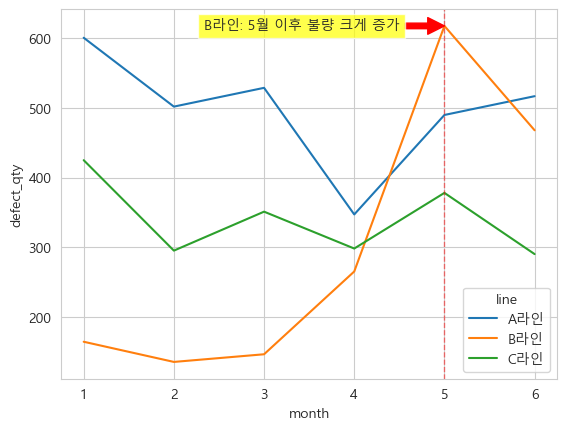

In [28]:
# 2. 5월 이후 B라인 불량이 증가했는지 확인
sns.lineplot(data=monthly_line_defect, x='month', y='defect_qty', hue='line', errorbar=None)
plt.axvline(5, color='red', linestyle='--', linewidth=1, alpha=0.5)

may_lineB_defect = monthly_line_defect[monthly_line_defect['month'] == 5].iloc[1, 2]
plt.annotate(f"B라인: 5월 이후 불량 크게 증가", xy=(5, may_lineB_defect),
             xytext=(5 - 0.5, may_lineB_defect),
             arrowprops=dict(color='red'),
             bbox=dict(fc='yellow', alpha=0.7), ha='right', va='center')

plt.show()

In [29]:
# 3. 심각도(severity)별 월별 추이도 확인하세요
monthly_severity_defect = defect.groupby(['month', 'severity'])['defect_qty'].sum().reset_index()
monthly_severity_defect

,month,severity,defect_qty
0,1,경미,333
1,1,보통,477
2,1,심각,380
3,2,경미,352
4,2,보통,319
5,2,심각,261
6,3,경미,357
7,3,보통,432
8,3,심각,237
9,4,경미,272


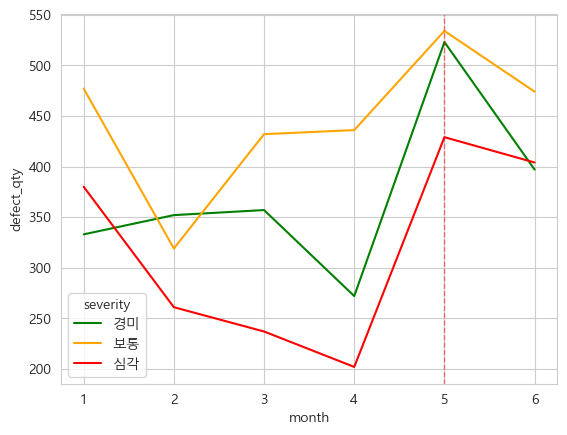

In [30]:
severity_colors = {'경미': 'green', '보통': 'orange', '심각': 'red'}

sns.lineplot(data=monthly_severity_defect, x='month', y='defect_qty', hue='severity', errorbar=None, palette=severity_colors)
plt.axvline(5, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.show()

### 문제 2-4: 불량 원인 심층 분석 (5점)

외관불량이 가장 많다면, 그 세부 원인은 무엇인가?

1. 불량 유형별 **세부 원인(cause)** 건수를 집계하세요
2. 상위 3개 불량 유형 각각의 원인 분포를 **서브플롯(1×3)**으로 시각화
   - 각 서브플롯은 수평 막대 차트
3. 불량 처리 방법(action)별 비율도 확인 (재작업 vs 폐기 vs 특채)

In [31]:
# 1. 불량 유형별 **세부 원인(cause)** 건수를 집계하세요
defect_type_cause = defect.groupby('defect_type')['cause'].value_counts()
defect_type_cause

defect_type  cause    
기타           조립불량         14
             포장손상         12
             라벨오류         11
             세척불량         11
외관불량         이물질부착        60
             스크래치         53
             찍힘           53
             변색           45
             버(burr)잔존    44
             원인미상         10
치수불량         측정오류         42
             열변형          41
             셋업오류         38
             소재경도편차       38
             공구마모         33
             원인미상          7
크랙           소재결함         18
             열처리불량        18
             과부하가공        15
             응력집중         13
             원인미상          3
표면조도불량       냉각부족         24
             소재불량         24
             절삭조건부적합      24
             공구마모         18
             원인미상          5
형상불량         동축도초과        25
             진원도초과        22
             프로그램오류       22
             평탄도초과        17
             원인미상          7
Name: count, dtype: int64

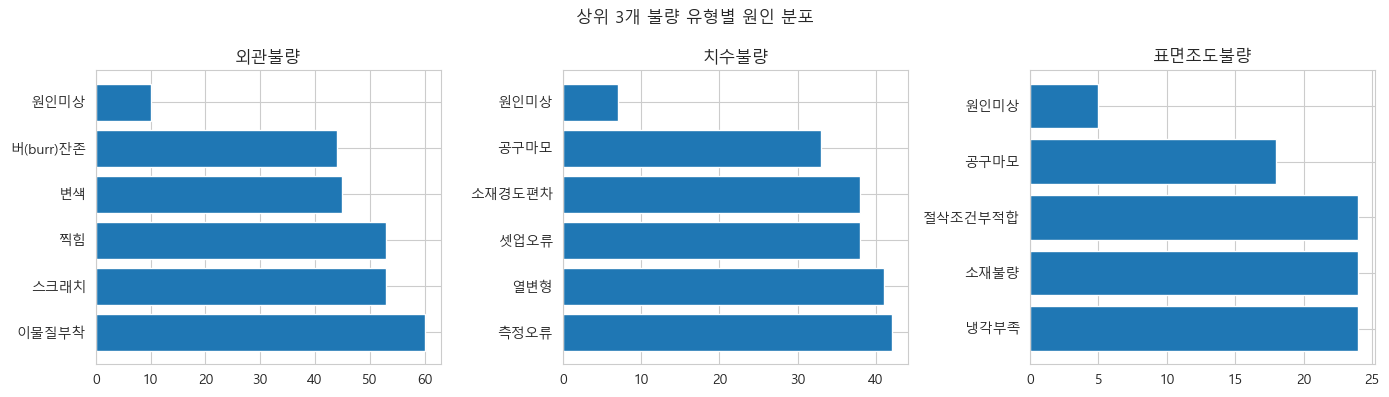

In [32]:
# 2. 상위 3개 불량 유형 각각의 원인 분포를 **서브플롯(1×3)**으로 시각화
#    - 각 서브플롯은 수평 막대 차트
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

for ax, idx in zip(axs, defect_type_cause.groupby('defect_type').sum().nlargest(3).index):
    ax.barh(y=defect_type_cause.loc[idx].index, width=defect_type_cause.loc[idx].values)
    ax.set_title(idx)

plt.suptitle('상위 3개 불량 유형별 원인 분포')

plt.tight_layout()
plt.show()

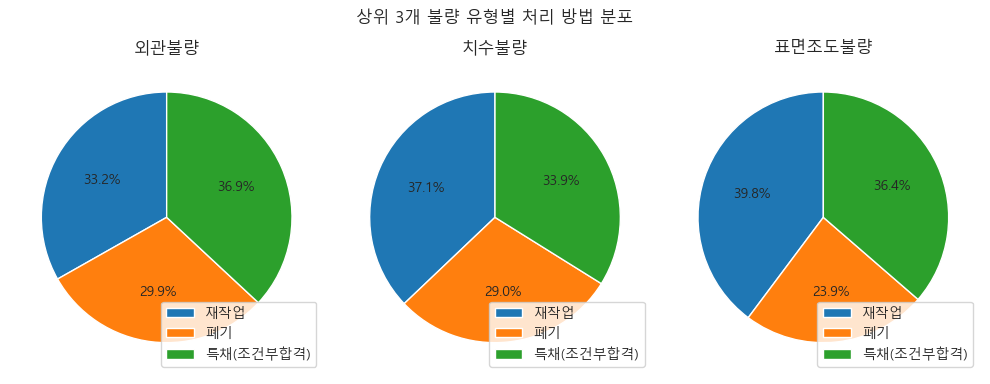

In [33]:
# 3. 불량 처리 방법(action)별 비율도 확인 (재작업 vs 폐기 vs 특채)
defect_type_action = pd.pivot_table(defect, index='defect_type', columns='action', values='defect_id', aggfunc='count')
defect_type_action['sum'] = defect_type_action.sum(axis=1)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, idx in zip(axs, defect_type_action.nlargest(3, columns='sum').index):
    ax.pie(defect_type_action.loc[idx, ['재작업', '폐기', '특채(조건부합격)']], autopct='%1.1f%%', startangle=90)
    ax.legend(['재작업', '폐기', '특채(조건부합격)'], loc='lower right')
    ax.set_title(idx)

plt.suptitle('상위 3개 불량 유형별 처리 방법 분포')

plt.tight_layout()
plt.show()

---
## Part 3: SPC 관리도 & 공정능력 분석 (30점)

**SPC(Statistical Process Control, 통계적 공정 관리)**는  
공정의 변동을 **우연원인**(자연스러운 산포)과 **특수원인**(이상 변동)으로 구분합니다.

### 관리도의 핵심 개념

```
중심선 (CL) = 전체 평균 (X̄)
관리 상한 (UCL) = X̄ + 3σ
관리 하한 (LCL) = X̄ - 3σ

관리 이탈 판정 규칙 (Nelson Rules 중 기본):
  Rule 1: 점이 UCL/LCL 밖에 위치
  Rule 2: 연속 7개 점이 중심선 같은 쪽
```

> **현업 포인트**: 관리도에서 '이탈'이 발견되면 즉시 현장에 알리고 원인을 조사합니다.  
> 관리도는 '판정 도구'가 아니라 '신호 탐지 도구'입니다.

### 문제 3-1: PRD-003(샤프트-A) 직경 관리도 (10점)

고객이 클레임한 PRD-003 직경을 SPC로 분석합니다.

1. `insp`에서 PRD-003 + 직경 데이터만 필터링
2. 로트별(lot_id) 평균값(X̄)과 범위(R)를 계산하세요
3. **X̄-R 관리도**를 그리세요 (2행 1열 서브플롯):
   - 상단: X̄ 관리도 (CL, UCL, LCL, 규격선 USL/LSL 포함)
   - 하단: R 관리도 (CL, UCL)
   - 관리 이탈점은 빨간색으로 표시
   - Figure 크기: (16, 10)

**X̄ 관리도 계수 (n=5일 때):**
```
A2 = 0.577
D3 = 0
D4 = 2.114

X̄ 관리도:
  CL = X̿ (X̄들의 전체 평균)
  UCL = X̿ + A2 × R̄
  LCL = X̿ - A2 × R̄

R 관리도:
  CL = R̄ (R들의 평균)
  UCL = D4 × R̄
  LCL = D3 × R̄
```

In [36]:
# 1. `insp`에서 PRD-003 + 직경 데이터만 필터링
insp[(insp['product_code'] == 'PRD-003') & (insp['spec_name'] == '직경')]

,inspection_id,lot_id,lot_no,inspection_date,shift,line,product_code,spec_name,unit,target_value,lsl,usl,measurement,result,sample_no,inspector_id,month,deviation,is_fail,within_spec
20,QC-000021,L00021,LOT-240101-A주-003,2024-01-01,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0186,PASS,1,INS-05,1,0.0186,False,True
24,QC-000025,L00021,LOT-240101-A주-003,2024-01-01,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,19.9848,PASS,2,INS-05,1,-0.0152,False,True
28,QC-000029,L00021,LOT-240101-A주-003,2024-01-01,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,19.9948,PASS,3,INS-05,1,-0.0052,False,True
32,QC-000033,L00021,LOT-240101-A주-003,2024-01-01,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0061,PASS,4,INS-05,1,0.0061,False,True
36,QC-000037,L00021,LOT-240101-A주-003,2024-01-01,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0009,PASS,5,INS-05,1,0.0009,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42400,QC-042401,L42401,LOT-240629-A주-003,2024-06-29,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0145,PASS,1,INS-03,6,0.0145,False,True
42404,QC-042405,L42401,LOT-240629-A주-003,2024-06-29,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0070,PASS,2,INS-03,6,0.0070,False,True
42408,QC-042409,L42401,LOT-240629-A주-003,2024-06-29,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0048,PASS,3,INS-03,6,0.0048,False,True
42412,QC-042413,L42401,LOT-240629-A주-003,2024-06-29,주간,A라인,PRD-003,직경,mm,20.0,19.98,20.02,20.0055,PASS,4,INS-03,6,0.0055,False,True


In [ ]:
# 2. 로트별(lot_id) 평균값(X̄)과 범위(R)를 계산하세요


In [ ]:
# 3. **X̄-R 관리도**를 그리세요 (2행 1열 서브플롯):
#    - 상단: X̄ 관리도 (CL, UCL, LCL, 규격선 USL/LSL 포함)
#    - 하단: R 관리도 (CL, UCL)
#    - 관리 이탈점은 빨간색으로 표시
#    - Figure 크기: (16, 10)

### 문제 3-2: PRD-003 직경 공정능력 분석 (10점)

관리도로 공정 상태를 확인했으면, 이제 **공정이 규격을 만족하는지** 정량 평가합니다.

1. PRD-003 직경의 **전체** Cp, Cpk를 계산하세요
2. **라인별** Cp, Cpk를 계산하세요 (A라인 vs C라인)
3. Cpk 판정 결과를 해석하세요:
   - Cpk ≥ 1.33: 충분 / 1.0 ≤ Cpk < 1.33: 관리필요 / Cpk < 1.0: 부족
4. **히스토그램 + 규격선** 차트를 그리세요:
   - 라인별 (1×2 서브플롯)
   - 히스토그램 위에 정규분포 커브 오버레이
   - USL, LSL, Target 세로선 표시
   - Cp, Cpk 값을 차트 안에 텍스트로 표시
   - Figure 크기: (14, 5)

In [88]:
# 여기에 코드 작성


### 문제 3-3: PRD-005(기어박스커버) 두께 이상 탐지 (10점)

고객이 "5월 이후 두께가 커지고 있다"고 했습니다.  
SPC 관리도로 **특수원인 변동**을 탐지하세요.

1. PRD-005 + 두께 데이터를 필터링
2. **월별 평균**을 계산하여 추이를 확인
3. **1~4월 데이터만**으로 관리한계(CL, UCL, LCL)를 설정하세요  
   (정상 기간 기준으로 관리한계를 설정해야 5월 이후 이상을 탐지할 수 있음)
4. **개별값 관리도(I-MR chart)**를 그리세요:
   - 로트별 평균을 시계열로 표시
   - 1~4월 기준 관리한계선
   - 5월 이후 이탈점 빨간색 표시
   - Figure 크기: (16, 6)
5. Nelson Rule 2 (연속 7점 같은 쪽) 위반 여부도 확인

In [89]:
# 여기에 코드 작성


---
## Part 4: 공정 파라미터 영향 분석 (15점)

불량의 원인을 찾으려면 **공정 조건(파라미터)**과 **품질 결과**의 관계를 분석해야 합니다.  
온도가 높으면 열변형이 발생하고, 진동이 크면 표면 품질이 나빠질 수 있습니다.

> **현업 포인트**: 상관관계 ≠ 인과관계이지만, 상관이 있는 파라미터는 관리 우선순위가 높습니다.

### 문제 4-1: 공정 파라미터 상관관계 분석 (5점)

1. `params`의 수치형 컬럼 간 **상관관계 히트맵**을 그리세요
   - `annot=True, fmt='.2f', cmap='coolwarm', center=0`
2. `has_defect`(불량 발생 여부)와 가장 상관이 높은 파라미터는?
3. 라인별로 상관관계가 다른지 비교하세요 (라인별 3개 히트맵)

In [90]:
# 여기에 코드 작성


### 문제 4-2: 불량 발생 조건 분석 (5점)

1. `has_defect == 1`(불량 발생)과 `has_defect == 0`(정상) 그룹의  
   주요 파라미터 평균을 비교하는 표를 만드세요
2. **온도(temperature_c) 구간별 불량률**을 계산하세요:
   - 구간: ~35, 35~40, 40~45, 45~50, 50~ (pd.cut 사용)
   - 구간별 불량률 = has_defect 합계 / 건수 × 100
   - **막대 차트**로 시각화
3. 불량 발생 임계 온도가 있는지 확인

In [91]:
# 여기에 코드 작성


### 문제 4-3: 검사원별 측정 편차 분석 (5점)

측정 시스템 신뢰성도 중요합니다.  
같은 제품을 다른 검사원이 측정했을 때 결과가 달라지면 문제입니다.

1. PRD-001 외경에 대해 **검사원별 평균 측정값**을 비교하세요
2. **박스플롯**으로 검사원별 측정값 분포를 비교 (x=inspector_id, y=measurement)
3. 특정 검사원(INS-07, INS-08)의 측정값이 다른 검사원보다 체계적으로 높은지 확인
4. 검사원 간 차이가 유의한지 **ANOVA (일원분산분석)** 수행
   - `stats.f_oneway(group1, group2, ...)` 사용

In [92]:
# 여기에 코드 작성


---
## Part 5: 품질 종합 보고서 대시보드 (15점)

분석 결과를 **품질 관리 보고서 형태의 대시보드**로 정리합니다.

### 문제 5-1: 품질 종합 대시보드 (15점)

`plt.subplot()` 또는 `GridSpec`으로 **2행 3열 (6패널)** 대시보드를 만드세요.  
Figure 크기: (20, 12)

| 위치 | 차트 | 내용 |
|------|------|------|
| (1,1) | 파레토 차트 | 불량 유형별 수량 + 누적비율 |
| (1,2) | 히트맵 | 라인 × 불량유형 불량수량 |
| (1,3) | 라인 차트 | 월별 불량 수량 추이 (라인별) |
| (2,1) | 히스토그램 | PRD-003 직경 분포 + 규격선 |
| (2,2) | 관리도 | PRD-005 두께 시계열 (관리한계 포함) |
| (2,3) | 막대 차트 | 온도 구간별 불량률 |

**스타일:**
- 전체 제목: '한국정밀산업(주) 품질관리 보고서 (2024년 상반기)'
- 각 패널에 소제목
- `plt.tight_layout()` 적용

In [93]:
# 여기에 코드 작성


---
## 분석 결론 작성

고객 클레임에 대응하기 위한 분석 보고서를 작성하세요:

1. **불량 현황 요약**: 주요 불량 유형과 발생 패턴
2. **PRD-003 샤프트-A 직경 문제**: Cpk 수치, 문제의 심각성, 라인별 차이
3. **PRD-005 기어박스커버 두께 이상**: 5월 이후 평균 이동 원인 추정
4. **공정 파라미터 영향**: 온도·진동과 품질의 관계
5. **검사 시스템 문제**: 검사원 간 편차 여부
6. **개선 제안**: 구체적인 3가지 이상의 조치 방안

### 분석 결론 (여기에 작성)

1. **불량 현황 요약**: 

2. **PRD-003 직경 문제**: 

3. **PRD-005 두께 이상**: 

4. **공정 파라미터 영향**: 

5. **검사 시스템 문제**: 

6. **개선 제안**: 


---
## 수고하셨습니다!

### 학습 체크리스트
- [ ] 파레토 분석으로 핵심 불량 원인 도출
- [ ] 라인별·제품별·월별 불량 추이 분석
- [ ] X̄-R 관리도 작성 및 관리 이탈점 식별
- [ ] 공정능력지수 Cp/Cpk 계산 및 해석
- [ ] 히스토그램 + 규격선으로 공정능력 시각화
- [ ] 특수원인 변동 탐지 (평균 이동)
- [ ] 공정 파라미터와 품질의 상관관계 분석
- [ ] 검사원 간 측정 편차 분석 (ANOVA)
- [ ] 종합 품질 대시보드 구성